In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

## Loading data from CSV to Pandas DataFrame

In [2]:
data = pd.read_csv("DataSet_PCP_Change.csv")
data.head()

,testindex,outcome,distance,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
0,0,0,0.071912,0,NaN,2.0,0,0,0,0,0,1,0,0
1,2,0,0.448447,0,NaN,1.0,0,0,1,1,1,0,0,0
2,5,0,0.345793,0,NaN,1.0,0,1,0,0,0,1,0,0
3,6,0,1.857032,0,NaN,1.0,0,0,1,1,1,1,0,0
4,7,1,7.222060,0,NaN,1.0,0,0,1,1,0,0,0,0


In [3]:
data.describe()

,testindex,outcome,distance,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
count,3130.000000,3130.000000,3130.000000,3130.000000,556.000000,3121.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,2519.981789,0.040575,2.851791,1.074121,135.330935,1.814803,0.192332,0.442173,0.341853,0.376997,0.392332,0.511821,0.064856,0.065495
std,1439.130702,0.197335,5.797008,3.160802,121.441560,0.991786,0.394196,0.496724,0.474406,0.484712,0.488348,0.499940,0.246311,0.247437
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1271.250000,0.000000,0.466053,0.000000,49.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2520.500000,0.000000,1.015903,0.000000,100.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3769.750000,0.000000,2.195092,0.000000,185.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,5000.000000,1.000000,50.000000,36.000000,736.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
data.groupby(by='outcome', as_index=False).agg({'testindex': pd.Series.nunique})

,outcome,testindex
0,0,3003
1,1,127


In [5]:
data[data['outcome'] == 1].head()

,testindex,outcome,distance,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
4,7,1,7.222060,0,NaN,1.0,0,0,1,1,0,0,0,0
21,29,1,0.376928,5,0.0,1.0,0,0,0,1,0,0,0,0
25,37,1,6.557357,9,27.0,1.0,0,1,0,0,0,1,0,0
42,69,1,0.171770,0,NaN,2.0,0,0,0,0,0,0,0,0
72,116,1,0.303698,0,NaN,3.0,0,0,0,0,0,1,0,0


## Feture Enrichement

Binning for feature `distance` is required as the boxplot clearly shows that mostly distance is in range 0 to 5. 
Raw values of feature `distance` will lead to inaccurate predictions

In [6]:
# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=['outcome'], inplace=True)
y = data.outcome
data.drop(['outcome'], axis=1, inplace=True)

In [7]:
# replace all NaN with 0 from the claims_daysaway column dataset
data = data.fillna(0)

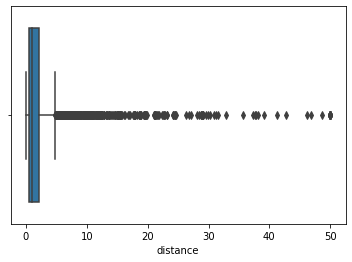

In [8]:
ax = sns.boxplot(x=data.distance)

In [9]:
# zone_labels = ["zone1", "zone2", "zone3", "zone4"]
zone_labels = ["1", "2", "3", "4"]
data['distance_bin'] = pd.cut(data['distance'], bins=[0, 2, 5, 10, 60], labels=zone_labels, include_lowest=True)
# categories = np.array(zone_labels)
# data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=categories, ordered=True)

data.drop(['distance'], axis=1, inplace=True)

# convert dtype from category to float
data["distance_bin"] = data.distance_bin.astype(float)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 0 to 3129
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   testindex          3130 non-null   int64  
 1   visit_count        3130 non-null   int64  
 2   claims_daysaway    3130 non-null   float64
 3   tier               3130 non-null   float64
 4   fqhc               3130 non-null   int64  
 5   pcp_lookback       3130 non-null   int64  
 6   family_assignment  3130 non-null   int64  
 7   kid                3130 non-null   int64  
 8   is_ped             3130 non-null   int64  
 9   same_gender        3130 non-null   int64  
 10  same_language      3130 non-null   int64  
 11  same_address       3130 non-null   int64  
 12  distance_bin       3130 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 342.3 KB


In [11]:
data.describe()

,testindex,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address,distance_bin
count,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,2519.981789,1.074121,24.039617,1.809585,0.192332,0.442173,0.341853,0.376997,0.392332,0.511821,0.064856,0.065495,1.473482
std,1439.130702,3.160802,72.747243,0.995116,0.394196,0.496724,0.474406,0.484712,0.488348,0.499940,0.246311,0.247437,0.883118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1271.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2520.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3769.750000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,5000.000000,36.000000,736.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


### Histogram to visualize all the possible features and the spread of their values.

array([[<AxesSubplot:title={'center':'testindex'}>,
        <AxesSubplot:title={'center':'visit_count'}>,
        <AxesSubplot:title={'center':'claims_daysaway'}>,
        <AxesSubplot:title={'center':'tier'}>],
       [<AxesSubplot:title={'center':'fqhc'}>,
        <AxesSubplot:title={'center':'pcp_lookback'}>,
        <AxesSubplot:title={'center':'family_assignment'}>,
        <AxesSubplot:title={'center':'kid'}>],
       [<AxesSubplot:title={'center':'is_ped'}>,
        <AxesSubplot:title={'center':'same_gender'}>,
        <AxesSubplot:title={'center':'same_language'}>,
        <AxesSubplot:title={'center':'same_address'}>],
       [<AxesSubplot:title={'center':'distance_bin'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

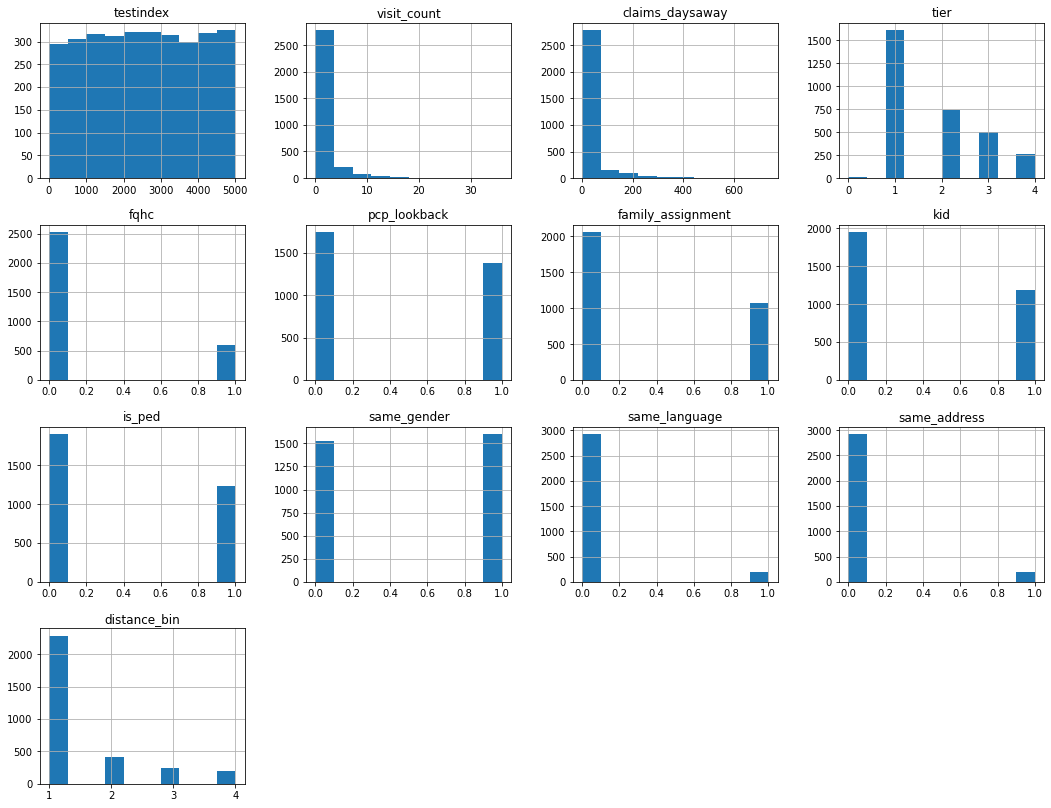

In [12]:
data.hist(figsize=(18,14))

In [18]:
print(data.shape, y.shape)
print(data.columns)

(3130, 13) (3130,)
Index(['testindex', 'visit_count', 'claims_daysaway', 'tier', 'fqhc',
       'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender',
       'same_language', 'same_address', 'distance_bin'],
      dtype='object')


## Split the data in Training and Testing dataset using `train_test_split` method from sklearn.

In [14]:
# Break-off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(data, y, train_size=0.8, test_size=0.2, random_state=0)

In [20]:
features = ['visit_count', 'claims_daysaway', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender', 'same_language', 'same_address', 'distance_bin']

## Models and Predictions

In [26]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

mean_absolute_error(y_valid, preds)

0.0706012703341539

In [27]:
model = LogisticRegression()
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

mean_absolute_error(y_valid, preds)

/opt/miniconda3/envs/bits-py-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.038338658146964855

In [28]:
model = DecisionTreeClassifier()
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

mean_absolute_error(y_valid, preds)

0.04792332268370607